# 1.8g: Halo Characterization

This notebook quantifies the geometric properties of the halo—the 1,423 unreachable tokens that are NOT part of the tight cluster.

## The Questions

From 1.8f, we confirmed the halo exists and shows spatial correlation with the cluster, but with strong anisotropy. Now we want to characterize it quantitatively:

1. **Radial structure:** How far are halo tokens from cluster centroid? What's the distribution?
2. **Centroid offset:** Is the halo centered on the cluster, or offset?
3. **Angular distribution:** What's the structure of the anisotropy?

## Method

We'll:
1. Compute L2 distances from each halo token to cluster centroid
2. Analyze distance distribution (min, max, mean, median, std)
3. Compute halo centroid and measure offset from cluster centroid
4. Create longitude/latitude heatmap to visualize angular anisotropy
5. Generate marginal histograms for longitude and latitude distributions

## Parameters

In [27]:
# Model
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Spherical coordinate system (from cluster centroid)
NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

# Visualization
FIGSIZE = (14, 10)
DPI = 150
CMAP = 'hot'  # Heat map colormap

## Imports

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from safetensors.torch import load_file
from pathlib import Path

## Device Detection

In [29]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [30]:
# Load W (full vocabulary)
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]
W = W_bf16.to(torch.float32).to(device)
N, d = W.shape

print(f"Loaded W: {W.shape}")
print(f"  {N:,} tokens in {d:,} dimensions")

Loaded W: torch.Size([151936, 2560])
  151,936 tokens in 2,560 dimensions


In [31]:
# Load cluster-centric reference frame
ref_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_reference_frame.safetensors")
ref_data = load_file(ref_path)
cluster_centroid = ref_data['cluster_centroid'].to(device)
eigenvectors = ref_data['W_eigenvectors'].to(device)

print(f"\nLoaded reference frame:")
print(f"  Cluster centroid: {cluster_centroid.shape}")
print(f"  Centroid norm: {torch.linalg.vector_norm(cluster_centroid).item():.6f}")


Loaded reference frame:
  Cluster centroid: torch.Size([2560])
  Centroid norm: 0.370917


In [32]:
# Load population masks from 1.8e
pop_path = Path(f"../tensors/{MODEL_NAME}/1.8e_unreachable_tokens.safetensors")
pop_data = load_file(pop_path)

cluster_mask = pop_data['cluster_mask']
halo_mask = pop_data['halo_mask']
halo_token_ids = pop_data['halo_token_ids']

print(f"\nLoaded population masks:")
print(f"  Cluster: {cluster_mask.sum().item():,} tokens")
print(f"  Halo: {halo_mask.sum().item():,} tokens")


Loaded population masks:
  Cluster: 2,212 tokens
  Halo: 1,423 tokens


## Extract Halo Token Vectors

In [33]:
print(f"\nExtracting halo token vectors...\n")

# Extract halo vectors
W_halo = W[halo_mask]
n_halo = W_halo.shape[0]

print(f"✓ Extracted {n_halo:,} halo token vectors")
print(f"  Shape: {W_halo.shape}")


Extracting halo token vectors...

✓ Extracted 1,423 halo token vectors
  Shape: torch.Size([1423, 2560])


## 1. Radial Structure: Distances from Cluster Centroid

In [34]:
print(f"\n{'='*70}")
print("RADIAL STRUCTURE")
print(f"{'='*70}\n")

# Compute L2 distances from cluster centroid
distances = torch.linalg.vector_norm(W_halo - cluster_centroid, dim=1)

# Statistics
d_min = distances.min().item()
d_max = distances.max().item()
d_mean = distances.mean().item()
d_median = distances.median().item()
d_std = distances.std().item()

print(f"L2 distances from cluster centroid:")
print(f"  Minimum:  {d_min:.6f}")
print(f"  Maximum:  {d_max:.6f}")
print(f"  Mean:     {d_mean:.6f}")
print(f"  Median:   {d_median:.6f}")
print(f"  Std Dev:  {d_std:.6f}")
print(f"\nHalo extent (max distance): {d_max:.6f}")
print(f"Halo radial spread (max - min): {d_max - d_min:.6f}")


RADIAL STRUCTURE

L2 distances from cluster centroid:
  Minimum:  0.005495
  Maximum:  1.453721
  Mean:     0.921032
  Median:   1.021091
  Std Dev:  0.309456

Halo extent (max distance): 1.453721
Halo radial spread (max - min): 1.448226


## Distance Distribution Histogram


Creating distance distribution histogram...



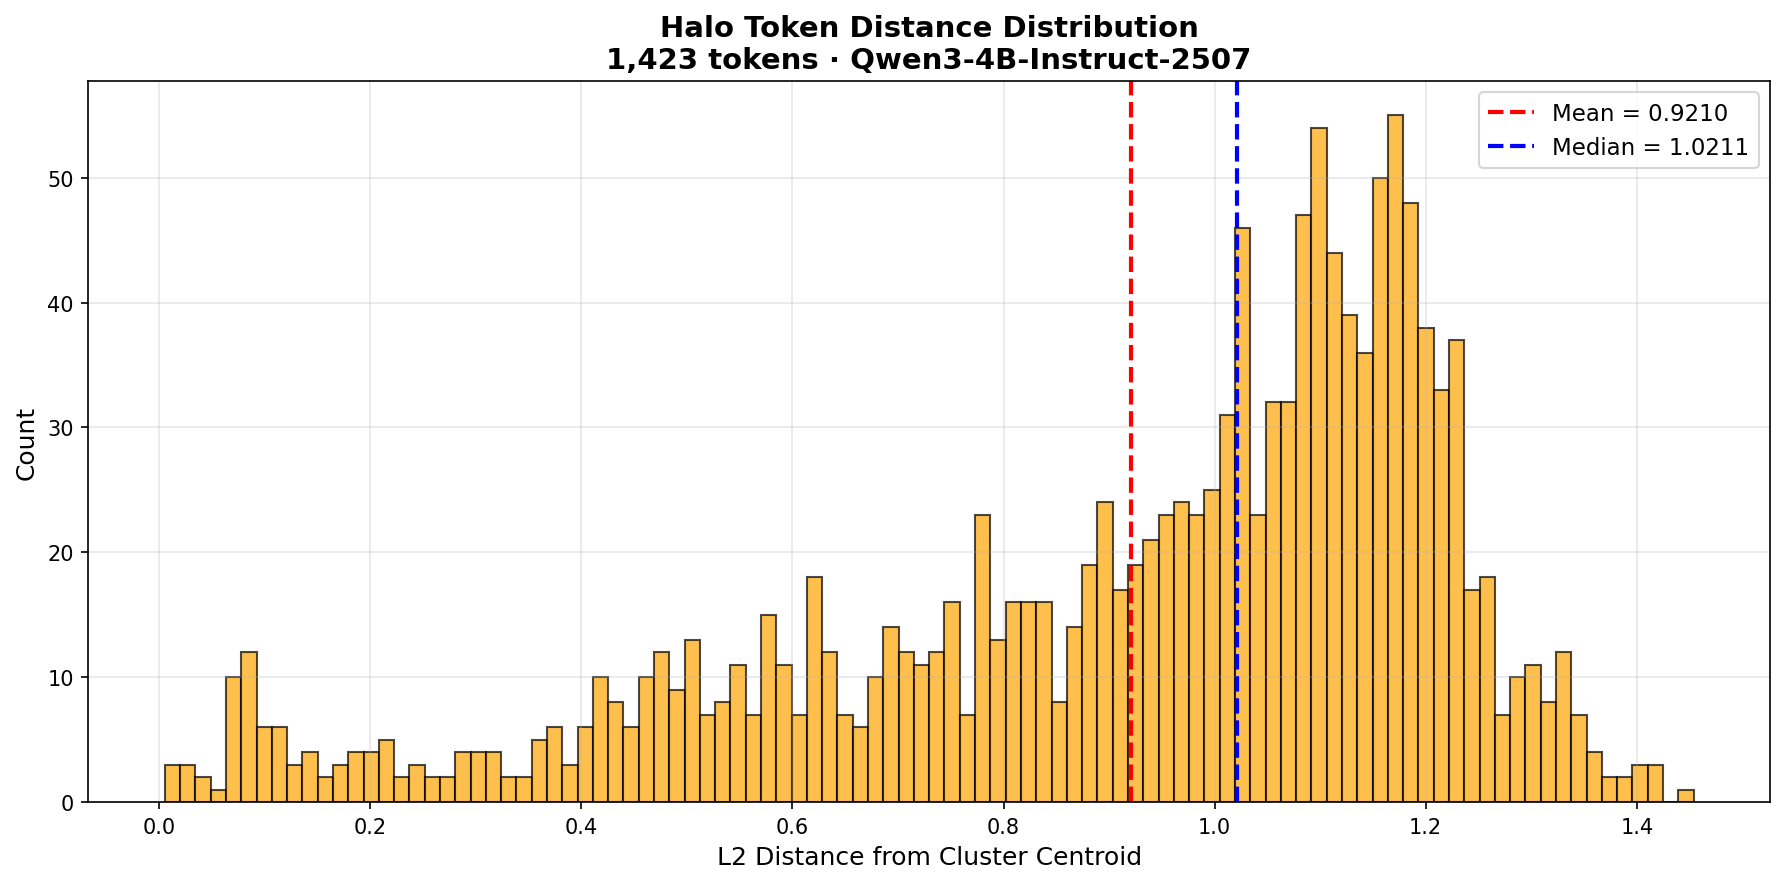

✓ Distance histogram complete


In [40]:
print(f"\nCreating distance distribution histogram...\n")

distances_np = distances.cpu().numpy()

fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

ax.hist(distances_np, bins=100, color='orange', alpha=0.7, edgecolor='black')
ax.axvline(d_mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {d_mean:.4f}')
ax.axvline(d_median, color='blue', linestyle='--', linewidth=2, label=f'Median = {d_median:.4f}')

ax.set_xlabel('L2 Distance from Cluster Centroid', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Halo Token Distance Distribution\n{n_halo:,} tokens · {MODEL_NAME}',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Distance histogram complete")

## 2. Centroid Offset: Halo vs Cluster

In [41]:
print(f"\n{'='*70}")
print("CENTROID OFFSET")
print(f"{'='*70}\n")

# Compute halo centroid
halo_centroid = W_halo.mean(dim=0)

# Distance between centroids
centroid_offset = torch.linalg.vector_norm(halo_centroid - cluster_centroid).item()

# Halo centroid norm (from origin)
halo_centroid_norm = torch.linalg.vector_norm(halo_centroid).item()
cluster_centroid_norm = torch.linalg.vector_norm(cluster_centroid).item()

print(f"Cluster centroid (from origin):")
print(f"  L2 norm: {cluster_centroid_norm:.6f}")
print(f"\nHalo centroid (from origin):")
print(f"  L2 norm: {halo_centroid_norm:.6f}")
print(f"\nCentroid offset (halo - cluster):")
print(f"  L2 distance: {centroid_offset:.6f}")
print(f"\nInterpretation:")
if centroid_offset < d_mean / 10:
    print(f"  ✓ Halo is approximately CO-CENTERED with cluster")
    print(f"    (offset {centroid_offset:.6f} << mean halo radius {d_mean:.6f})")
elif centroid_offset < d_mean:
    print(f"  ~ Halo is SLIGHTLY OFFSET from cluster")
    print(f"    (offset {centroid_offset:.6f} ≈ {100*centroid_offset/d_mean:.1f}% of mean halo radius)")
else:
    print(f"  ✗ Halo is SIGNIFICANTLY OFFSET from cluster")
    print(f"    (offset {centroid_offset:.6f} ≥ mean halo radius {d_mean:.6f})")


CENTROID OFFSET

Cluster centroid (from origin):
  L2 norm: 0.370917

Halo centroid (from origin):
  L2 norm: 0.308297

Centroid offset (halo - cluster):
  L2 distance: 0.205583

Interpretation:
  ~ Halo is SLIGHTLY OFFSET from cluster
    (offset 0.205583 ≈ 22.3% of mean halo radius)


## 3. Angular Distribution: Spherical Coordinates

In [42]:
print(f"\n{'='*70}")
print("ANGULAR DISTRIBUTION")
print(f"{'='*70}\n")

# Define spherical basis
def get_pc_vector(pcs, index):
    """Get PC vector by index, with sign flip for negative indices."""
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

print(f"Spherical basis (from cluster centroid):")
print(f"  North: PC{NORTH_PC}")
print(f"  Meridian: PC{MERIDIAN_PC}")
print(f"  Equinox: PC{EQUINOX_PC}")

# Translate to cluster-centric frame
W_halo_centered = W_halo - cluster_centroid

# Project onto basis
x = W_halo_centered @ meridian
y = W_halo_centered @ equinox
z = W_halo_centered @ north

# Spherical coordinates
r = torch.sqrt(x**2 + y**2 + z**2)
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print(f"\n✓ Computed spherical coordinates for {n_halo:,} halo tokens")

# Convert to numpy
lon_np = lon_deg.cpu().numpy()
lat_np = lat_deg.cpu().numpy()

print(f"\nLongitude distribution:")
print(f"  Range: [{lon_np.min():.1f}°, {lon_np.max():.1f}°]")
print(f"  Mean: {lon_np.mean():.1f}°")
print(f"  Median: {np.median(lon_np):.1f}°")

print(f"\nLatitude distribution:")
print(f"  Range: [{lat_np.min():.1f}°, {lat_np.max():.1f}°]")
print(f"  Mean: {lat_np.mean():.1f}°")
print(f"  Median: {np.median(lat_np):.1f}°")


ANGULAR DISTRIBUTION

Spherical basis (from cluster centroid):
  North: PC2
  Meridian: PC1
  Equinox: PC3

✓ Computed spherical coordinates for 1,423 halo tokens

Longitude distribution:
  Range: [-179.8°, 179.9°]
  Mean: -92.4°
  Median: -123.1°

Latitude distribution:
  Range: [-81.2°, 89.6°]
  Mean: 36.9°
  Median: 43.6°


## Longitude/Latitude Heatmap with Marginals


Creating longitude/latitude heatmap with marginal histograms...



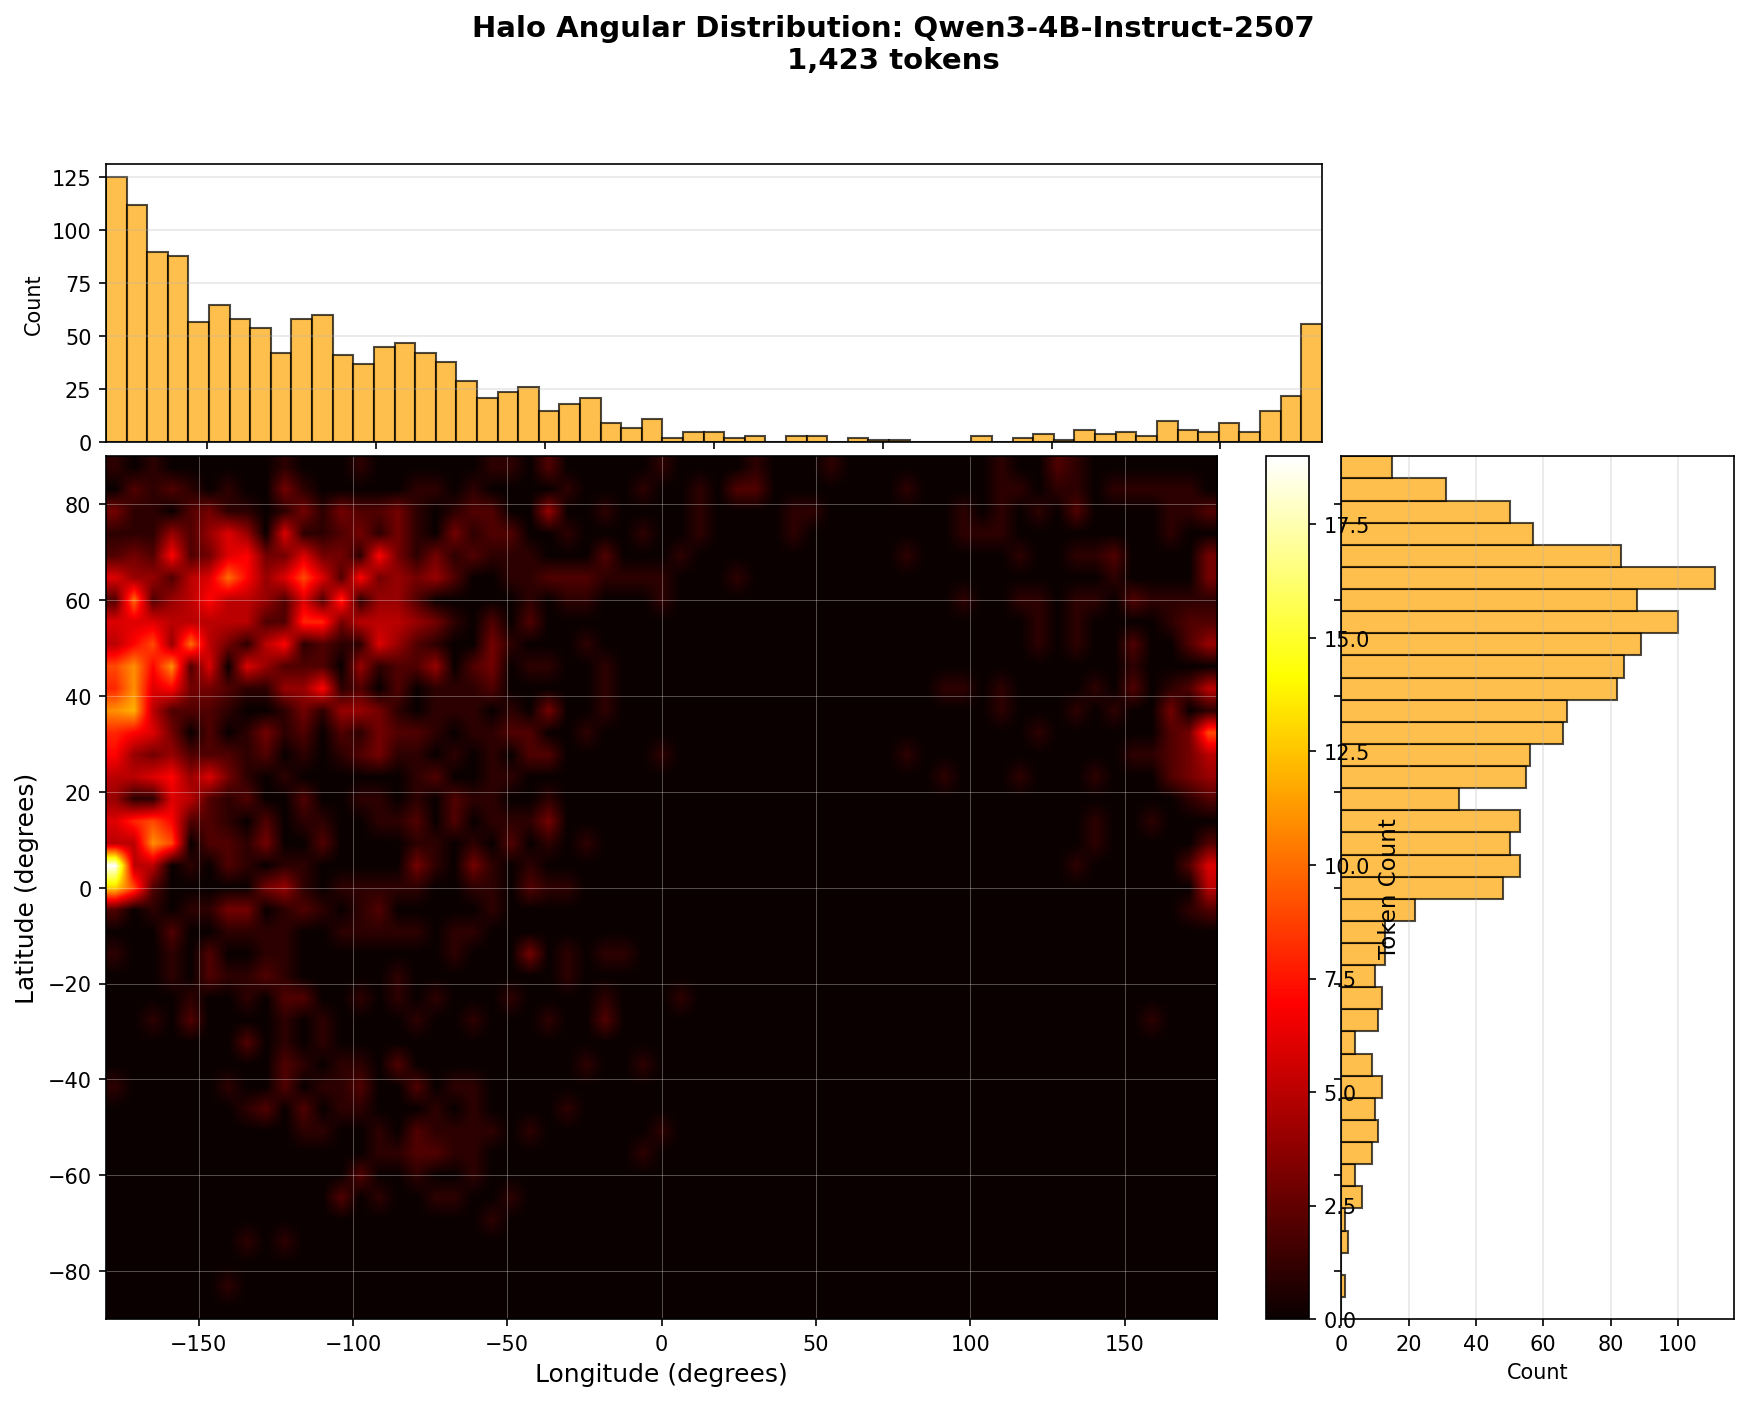

✓ Heatmap with marginals complete


In [43]:
print(f"\nCreating longitude/latitude heatmap with marginal histograms...\n")

# Create figure with GridSpec for layout
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
gs = GridSpec(4, 4, figure=fig, hspace=0.05, wspace=0.05)

# Main heatmap (bottom-left, large)
ax_main = fig.add_subplot(gs[1:4, 0:3])

# Marginal histograms
ax_lon = fig.add_subplot(gs[0, 0:3], sharex=ax_main)  # Top (longitude)
ax_lat = fig.add_subplot(gs[1:4, 3], sharey=ax_main)  # Right (latitude)

# Create 2D histogram (heatmap)
lon_bins = np.linspace(-180, 180, 60)
lat_bins = np.linspace(-90, 90, 40)

heatmap, lon_edges, lat_edges = np.histogram2d(lon_np, lat_np, bins=[lon_bins, lat_bins])

# Plot heatmap
im = ax_main.imshow(heatmap.T, origin='lower', aspect='auto',
                     extent=[lon_edges[0], lon_edges[-1], lat_edges[0], lat_edges[-1]],
                     cmap=CMAP, interpolation='bilinear')

ax_main.set_xlabel('Longitude (degrees)', fontsize=12)
ax_main.set_ylabel('Latitude (degrees)', fontsize=12)
ax_main.grid(True, alpha=0.3, color='white', linewidth=0.5)

# Colorbar
cbar = plt.colorbar(im, ax=ax_main, fraction=0.046, pad=0.04)
cbar.set_label('Token Count', fontsize=11)

# Longitude histogram (top)
ax_lon.hist(lon_np, bins=lon_bins, color='orange', alpha=0.7, edgecolor='black')
ax_lon.set_ylabel('Count', fontsize=10)
ax_lon.tick_params(labelbottom=False)
ax_lon.grid(True, alpha=0.3, axis='y')

# Latitude histogram (right)
ax_lat.hist(lat_np, bins=lat_bins, orientation='horizontal', color='orange', alpha=0.7, edgecolor='black')
ax_lat.set_xlabel('Count', fontsize=10)
ax_lat.tick_params(labelleft=False)
ax_lat.grid(True, alpha=0.3, axis='x')

# Title
fig.suptitle(f'Halo Angular Distribution: {MODEL_NAME}\n{n_halo:,} tokens',
             fontsize=14, fontweight='bold', y=0.98)

plt.show()

print("✓ Heatmap with marginals complete")

## Summary Statistics Table

In [44]:
print(f"\n{'='*70}")
print("SUMMARY: HALO CHARACTERIZATION")
print(f"{'='*70}\n")

print(f"Population:")
print(f"  Halo tokens: {n_halo:,}")
print(f"\nRadial structure (from cluster centroid):")
print(f"  Min distance:    {d_min:.6f}")
print(f"  Max distance:    {d_max:.6f}")
print(f"  Mean distance:   {d_mean:.6f}")
print(f"  Median distance: {d_median:.6f}")
print(f"  Std deviation:   {d_std:.6f}")
print(f"  Radial spread:   {d_max - d_min:.6f}")
print(f"\nCentroid offset:")
print(f"  Cluster centroid norm: {cluster_centroid_norm:.6f}")
print(f"  Halo centroid norm:    {halo_centroid_norm:.6f}")
print(f"  Centroid separation:   {centroid_offset:.6f}")
print(f"  Offset / mean radius:  {100*centroid_offset/d_mean:.2f}%")
print(f"\nAngular distribution:")
print(f"  Longitude range: [{lon_np.min():.1f}°, {lon_np.max():.1f}°]")
print(f"  Latitude range:  [{lat_np.min():.1f}°, {lat_np.max():.1f}°]")
print(f"  Lon mean/median: {lon_np.mean():.1f}° / {np.median(lon_np):.1f}°")
print(f"  Lat mean/median: {lat_np.mean():.1f}° / {np.median(lat_np):.1f}°")


SUMMARY: HALO CHARACTERIZATION

Population:
  Halo tokens: 1,423

Radial structure (from cluster centroid):
  Min distance:    0.005495
  Max distance:    1.453721
  Mean distance:   0.921032
  Median distance: 1.021091
  Std deviation:   0.309456
  Radial spread:   1.448226

Centroid offset:
  Cluster centroid norm: 0.370917
  Halo centroid norm:    0.308297
  Centroid separation:   0.205583
  Offset / mean radius:  22.32%

Angular distribution:
  Longitude range: [-179.8°, 179.9°]
  Latitude range:  [-81.2°, 89.6°]
  Lon mean/median: -92.4° / -123.1°
  Lat mean/median: 36.9° / 43.6°


## Observations

### Radial Structure:
- **Distance distribution** shows how halo tokens are spread radially from cluster centroid
- **Max distance** defines halo extent
- Compare std deviation to mean: high ratio → diffuse, low ratio → shell-like

### Centroid Offset:
- **Small offset (< 10% of mean radius):** Halo is co-centered with cluster
- **Moderate offset (10-50%):** Halo center is displaced
- **Large offset (> 50%):** Halo and cluster are distinct structures

### Angular Distribution:
- **Heatmap** reveals anisotropy structure
- **Hot spots** show preferential angular occupation
- **Marginal histograms** quantify longitude vs latitude biases
- From 1.8f: we expect concentration in -135° to -180° longitude range

### Key Findings:
(Results will populate when notebook is run)